## Importing the Dependencies

In [3]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../Pre_trained')))

In [4]:
import numpy as np
import torch
from skimage import io, color
from utils import *
from utils.demo_utils import load_model
from utils.noise_model import get_noise
from helper_functions.helper_functions import show_img, gray_image, degradation_operator, convergence, generate_gaussian_kernel
from helper_functions.helper_functions import safe_psnr as psnr




## Loading and Testing the Pre - Trained Model

c:\Users\lenonvo\Desktop\UniV COURS\Project Image\Pre_trained\utils\demo_utils.py:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint_path, 

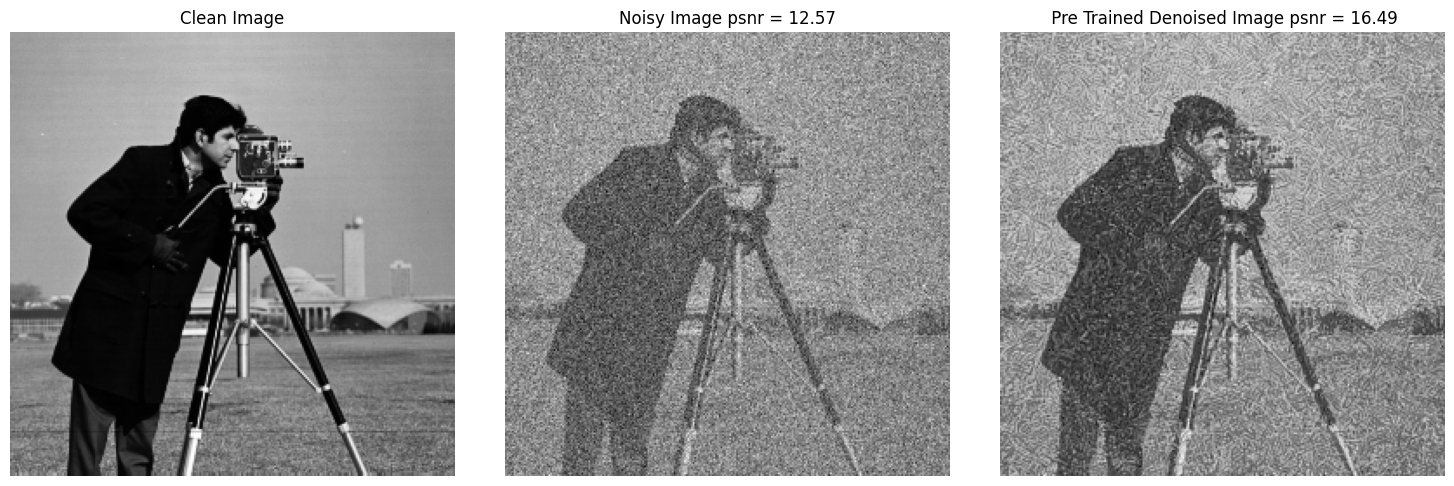

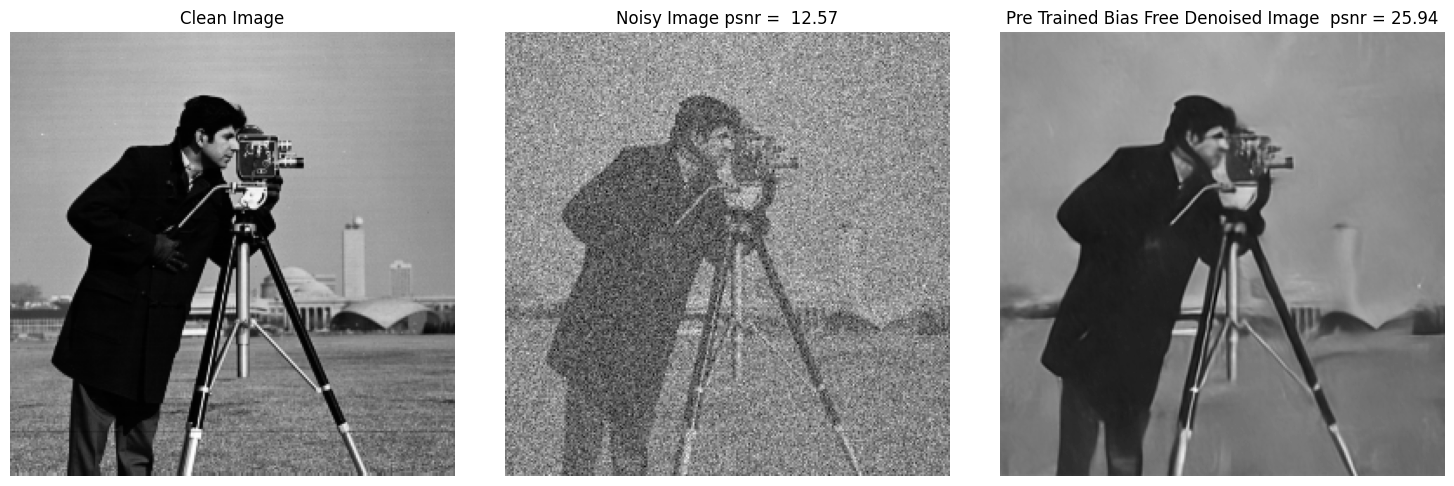

In [5]:
USE_CUDA = True
device = torch.device('cuda') if (torch.cuda.is_available() and USE_CUDA) else torch.device('cpu')

pretrained_base = '../Pre_trained/pretrained/'
precomputed_base = '../Pre_trained/precomputed/'
data_base = 'data/'

# Choose a model to load (options are: 'dncnn', 'unet', 'rcnn', 'sdensenet')
model = 'dncnn' 

# Select the range of training noise levels (stdev, relative to intensity range [0,255]). 
# Pre-computed options are 0-10, 0-30, 0-55, 0-100.
min_noise = 0   # lower bound of training range 
max_noise = 30  # upper bound of training range 
noise_level = 60

CNN = load_model(os.path.join(pretrained_base, model, 'bias', str(min_noise)+'-'+str(max_noise)+'.pt'))
BF_CNN = load_model(os.path.join(pretrained_base, model, 'bias_free', str(min_noise)+'-'+str(max_noise)+'.pt'))
img_path = '../test_images/cameraman.tif'

clean_im = io.imread(img_path).astype(float)/255

if len(clean_im.shape) == 3:
    clean_im = color.rgb2gray(clean_im)


clean_im_tensor = torch.from_numpy(clean_im).unsqueeze(0).unsqueeze(0).to(device).float()

noise = get_noise(clean_im_tensor, noise_std = noise_level/255., mode='S')
inp_test = clean_im_tensor + noise;
noisy_im = inp_test.cpu().data.squeeze(0).squeeze(0).numpy()
noisy_psnr = np.round(psnr(clean_im, noisy_im), 2)


denoised_dncnn= CNN(inp_test)
denoised_dncnn = denoised_dncnn.cpu().data.squeeze(0).squeeze(0).numpy()
denoised_dncnn_psnr = np.round(psnr(clean_im, denoised_dncnn), 2)


denoised_BF_dncnn= BF_CNN(inp_test)
denoised_BF_dncnn = denoised_BF_dncnn.cpu().data.squeeze(0).squeeze(0).numpy()
denoised_BF_dncnn_psnr = np.round(psnr(clean_im, denoised_BF_dncnn), 2)

show_img(clean_im, noisy_im, denoised_dncnn, titles=['Clean Image',f'Noisy Image psnr = {noisy_psnr}',f' Pre Trained Denoised Image psnr = {denoised_dncnn_psnr}'])
show_img(clean_im, noisy_im, denoised_BF_dncnn, titles=['Clean Image',f'Noisy Image psnr =  {noisy_psnr}',f'Pre Trained Bias Free Denoised Image  psnr = {denoised_BF_dncnn_psnr}'])

## Importing the Image

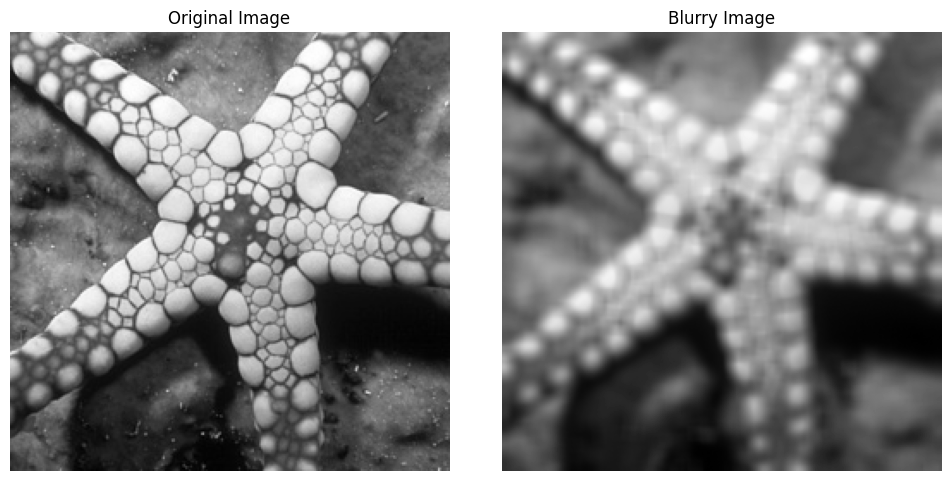

In [6]:
img_path = '../test_images/starfish.tif'
original_img = gray_image(img_path)
kernel = generate_gaussian_kernel(kernel_size = 9, sigma_blur = 19)
degraded_img = degradation_operator(original_img, kernel)

noise_std = 0.001
noisy_img = degraded_img + noise_std * np.random.randn(*degraded_img.shape)
show_img(original_img, noisy_img,  titles= ['Original Image', 'Blurry Image'])

## Running The Algorithms

### ADMM with a Neural Network Denoiser Engine

#### Classic Neural Network Denoiser(with Bias)

  0%|          | 0/70 [00:00<?, ?it/s]

100%|██████████| 70/70 [06:24<00:00,  5.50s/it]


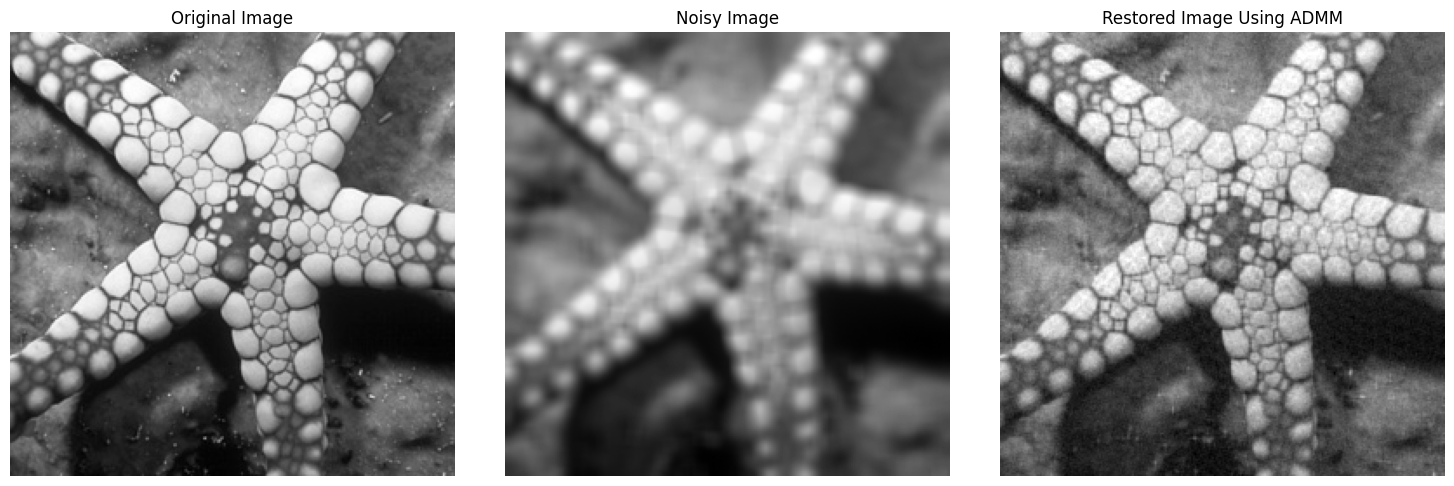

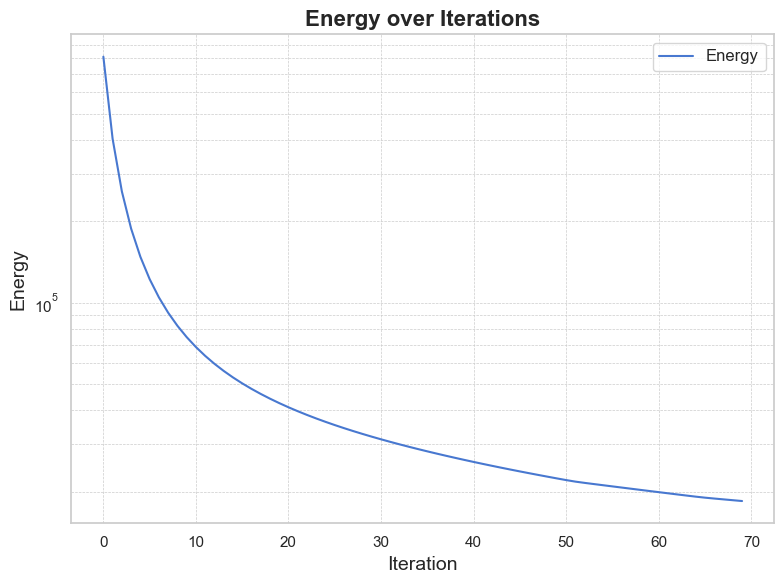

The original image psnr is :  inf dB
The noisy image psnr is :  21.580705797334883 dB
The reconstructed image psnr is :  28.853898375009223 dB


In [7]:
N = 70       
m1 = 10       
m2 = 1         
lambd = 0.01     
beta = 0.05     
sigma = 0.001
tol=1e-2

from ADMM_NN import RED_ADMM_Solver_NN

noisy_img = np.asarray(noisy_img)
red = RED_ADMM_Solver_NN(noisy_img, kernel, lambd, beta, sigma, N, m1, m2, CNN, tol)
restored_img_admm, energy_values = red.run()
show_img(original_img, noisy_img ,restored_img_admm, titles= ['Original Image', 'Noisy Image','Restored Image Using ADMM'])
convergence(energy_values)


print("The original image psnr is : ", psnr(original_img, original_img), "dB")
print("The noisy image psnr is : ",psnr(original_img, noisy_img), "dB")
print("The reconstructed image psnr is : ",psnr(original_img, restored_img_admm), "dB")

#### Bias Free Neural Network

  0%|          | 0/70 [00:00<?, ?it/s]

100%|██████████| 70/70 [08:29<00:00,  7.28s/it]


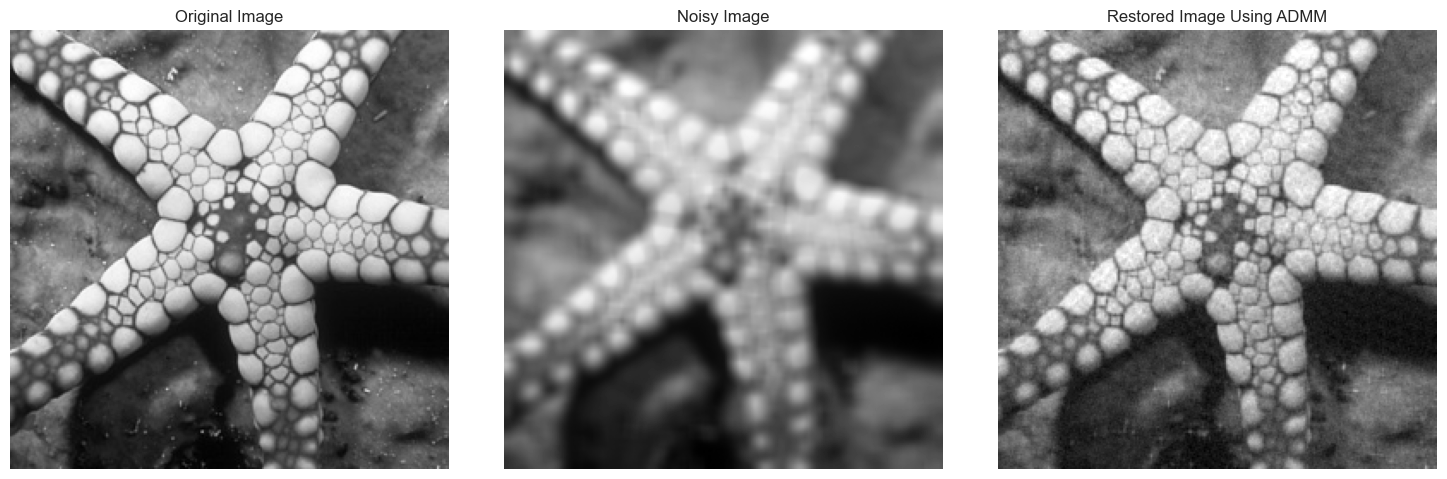

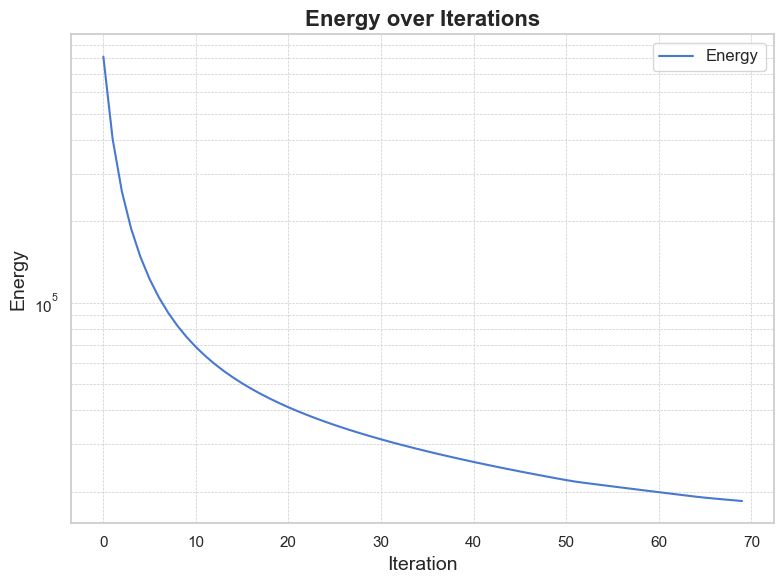

The original image psnr is :  inf dB
The noisy image psnr is :  21.580705797334883 dB
The reconstructed image psnr is :  28.853899311021497 dB


In [8]:
N = 70       
m1 = 10       
m2 = 1         
lambd = 0.01     
beta = 0.05     
sigma = 0.001
tol=1e-2

from ADMM_NN import RED_ADMM_Solver_NN

noisy_img = np.asarray(noisy_img)
red = RED_ADMM_Solver_NN(noisy_img, kernel, lambd, beta, sigma, N, m1, m2, BF_CNN, tol)
restored_img_admm, energy_values = red.run()
show_img(original_img, noisy_img ,restored_img_admm, titles= ['Original Image', 'Noisy Image','Restored Image Using ADMM'])
convergence(energy_values)


print("The original image psnr is : ", psnr(original_img, original_img), "dB")
print("The noisy image psnr is : ",psnr(original_img, noisy_img), "dB")
print("The reconstructed image psnr is : ",psnr(original_img, restored_img_admm), "dB")

### Fixed Point with a Neural Network Denoiser Engine 

#### Classic Neural Network(with Bias)

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [04:42<00:00,  5.65s/it]


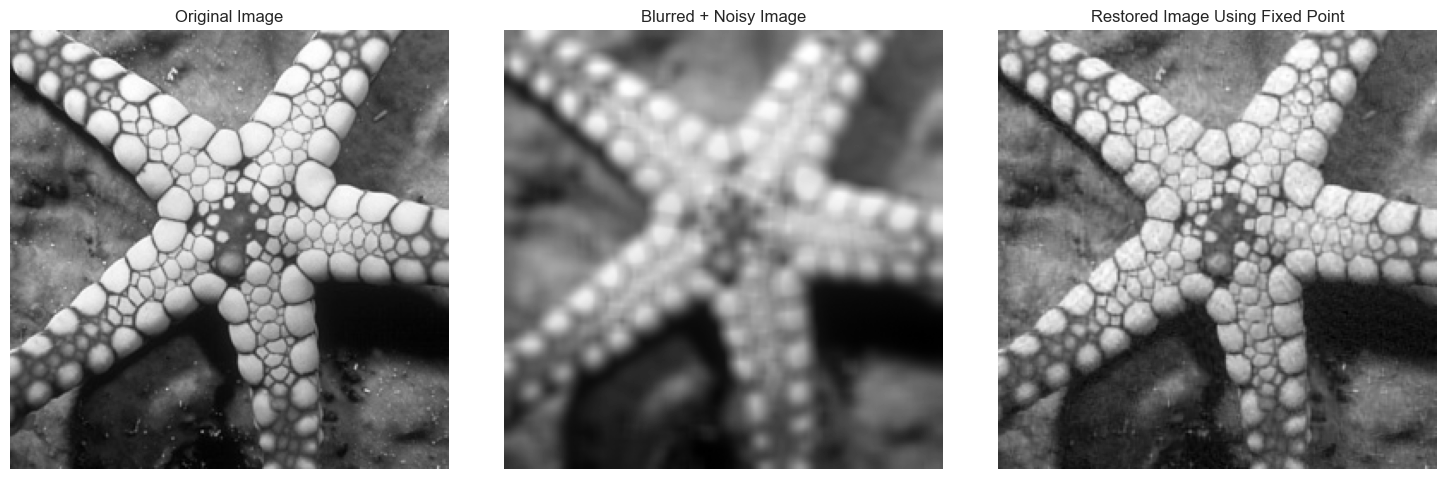

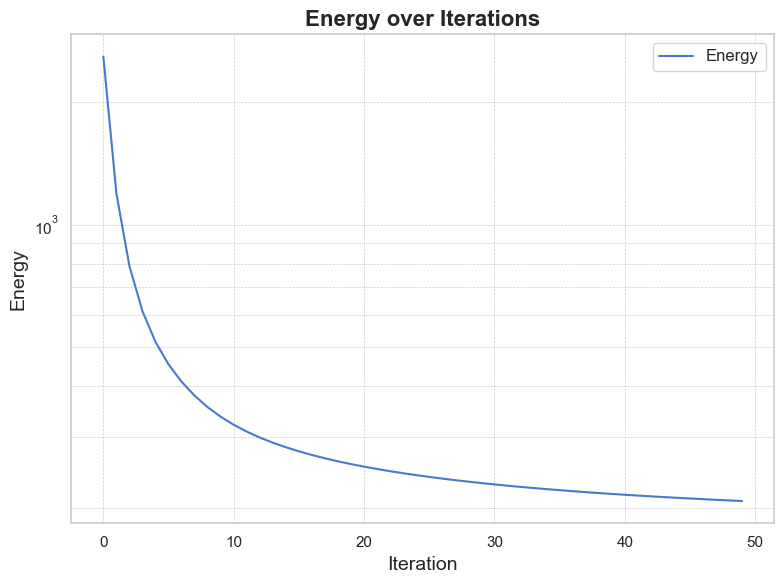

The original image psnr is :  inf dB
The noisy image psnr is :  21.580705797334883 dB
The reconstructed image psnr is :  29.973541052768425 dB


In [9]:
sigma = 0.01  
lambda_ = 0.01  
N = 50  
m = 30

from Fixed_Point_NN import fixed_point_red_NN

restored_img_fixed, energy_values = fixed_point_red_NN(
    y = noisy_img,
    kernel= kernel,
    sigma = sigma,
    lambda_= lambda_,
    N = N,
    m = m,
    model = CNN,
    tol=1e-10

)



show_img(original_img, noisy_img ,restored_img_fixed, titles= ['Original Image', 'Blurred + Noisy Image','Restored Image Using Fixed Point'])
convergence(energy_values)

print("The original image psnr is : ", psnr(original_img, original_img), "dB")
print("The noisy image psnr is : ",psnr(original_img, noisy_img), "dB")
print("The reconstructed image psnr is : ",psnr(original_img, restored_img_fixed), "dB")

#### Bias Free Neural Network

100%|██████████| 100/100 [13:48<00:00,  8.28s/it]


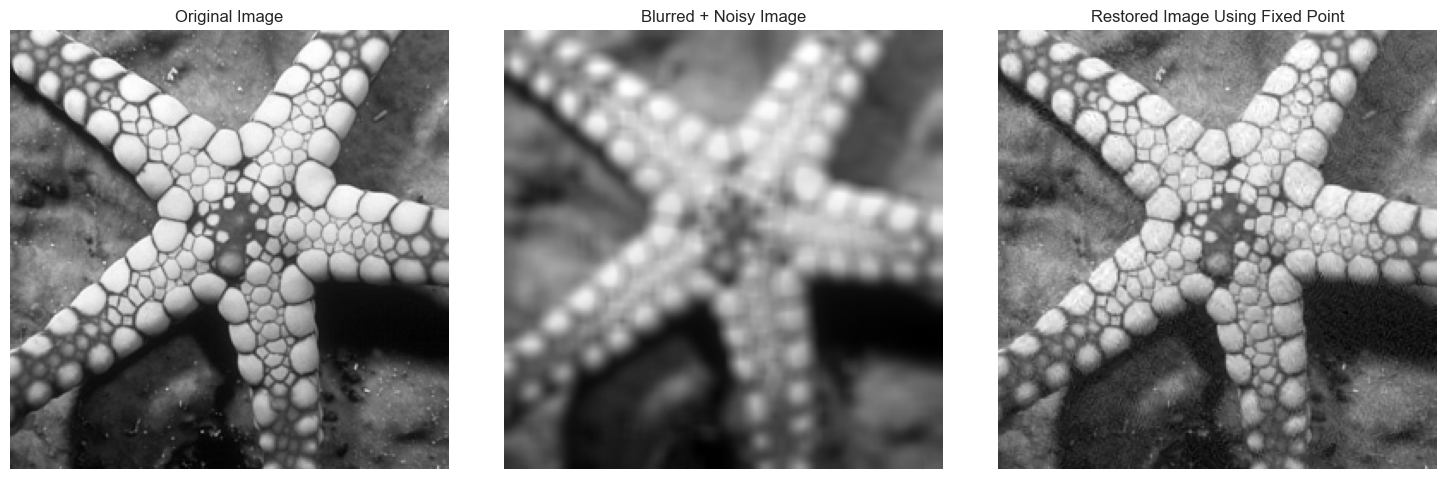

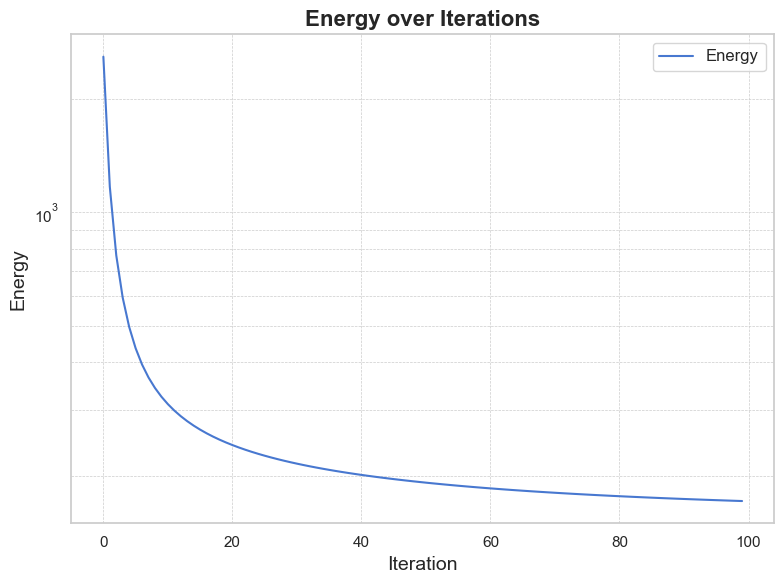

The original image psnr is :  inf dB
The noisy image psnr is :  21.580705797334883 dB
The reconstructed image psnr is :  30.06681431289372 dB


In [10]:
sigma = 0.01  
lambda_ = 0.01  
N = 100  
m = 30

from Fixed_Point_NN import fixed_point_red_NN

restored_img_fixed, energy_values = fixed_point_red_NN(
    y = noisy_img,
    kernel= kernel,
    sigma = sigma,
    lambda_= lambda_,
    N = N,
    m = m,
    model = BF_CNN

)



show_img(original_img, noisy_img ,restored_img_fixed, titles= ['Original Image', 'Blurred + Noisy Image','Restored Image Using Fixed Point'])
convergence(energy_values)

print("The original image psnr is : ", psnr(original_img, original_img), "dB")
print("The noisy image psnr is : ",psnr(original_img, noisy_img), "dB")
print("The reconstructed image psnr is : ",psnr(original_img, restored_img_fixed), "dB")

### Steepest Descent with a Neural Network Denoiser Engine

#### Classic Neural Network(with Bias)

100%|██████████| 500/500 [30:45<00:00,  3.69s/it]


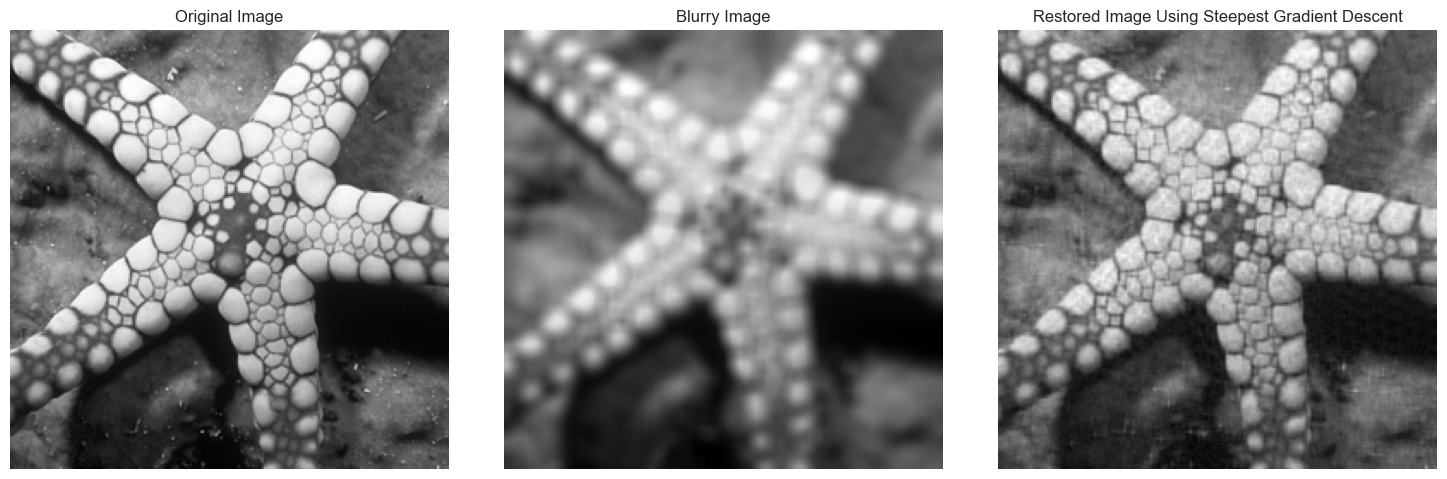

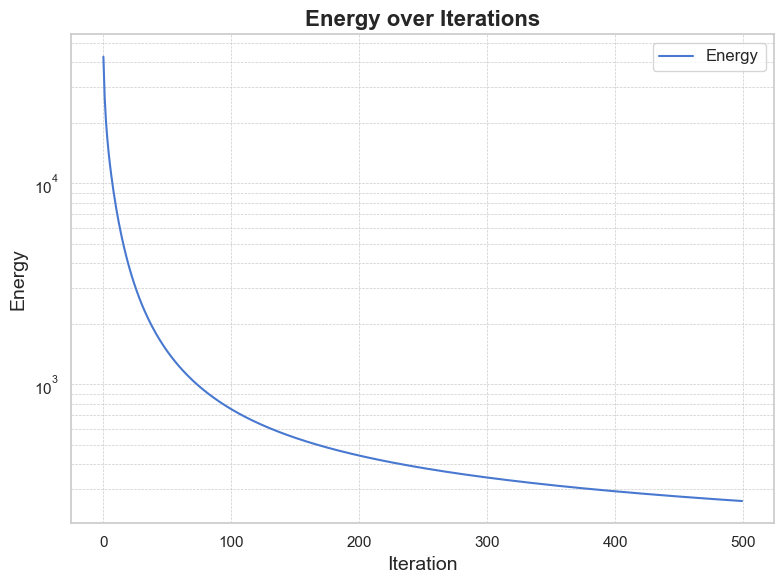

The original image psnr is :  inf dB
The noisy image psnr is :  21.580705797334883 dB
The reconstructed image psnr is :  28.396899731202495 dB


In [11]:
sigma = 0.01  
lambda_ = 0.01  
num_iterations = 500  
sigma_denoise = 0.001 

from Steepest_Descent_NN import steepest_descent_red_NN


restored_img_sg, energy_values = steepest_descent_red_NN(
        y=noisy_img,
        kernel= kernel,
        sigma=sigma,
        lambda_= lambda_,
        num_iterations=num_iterations,
        model = CNN,
        tol= 1e-6
    )

show_img(original_img, noisy_img ,restored_img_sg, titles= ['Original Image', 'Blurry Image','Restored Image Using Steepest Gradient Descent'])
convergence(energy_values)

print("The original image psnr is : ", psnr(original_img, original_img), "dB")
print("The noisy image psnr is : ",psnr(original_img, noisy_img), "dB")
print("The reconstructed image psnr is : ",psnr(original_img, restored_img_sg), "dB")

### Bias Free Neural Networks

100%|██████████| 500/500 [56:32<00:00,  6.78s/it]  


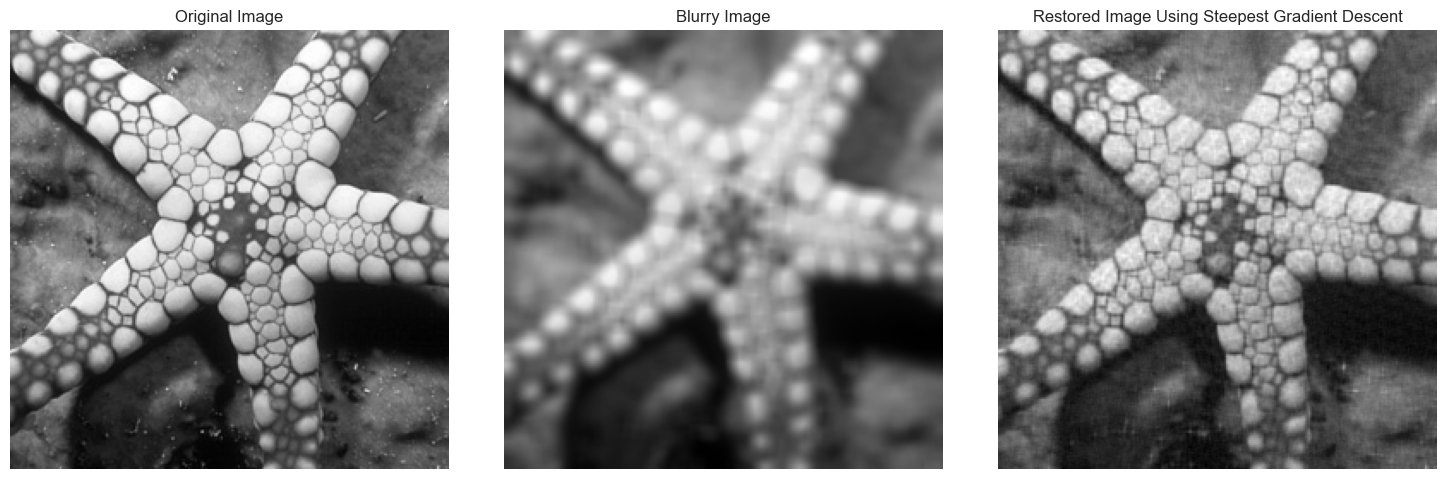

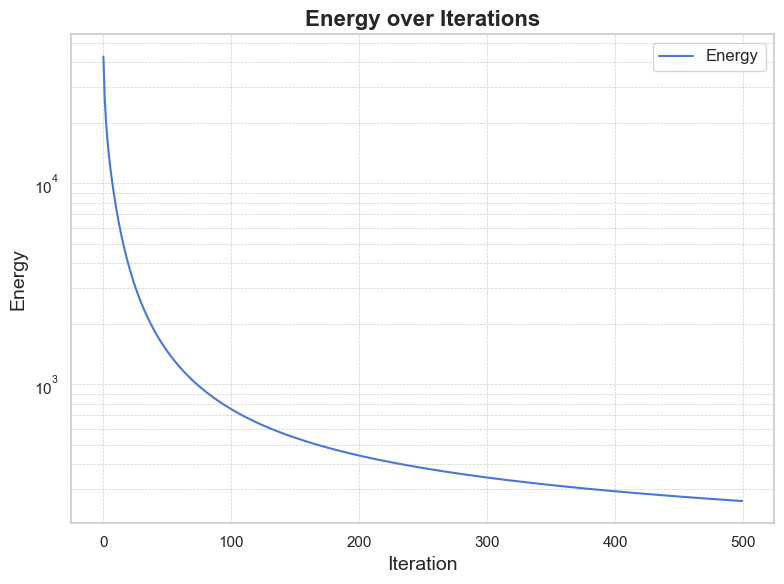

The original image psnr is :  inf dB
The noisy image psnr is :  21.580705797334883 dB
The reconstructed image psnr is :  28.396899211865186 dB


In [12]:
sigma = 0.01  
lambda_ = 0.01  
num_iterations = 500  
sigma_denoise = 0.001 

from Steepest_Descent_NN import steepest_descent_red_NN

# Run RED with steepest descent
restored_img_sg, energy_values = steepest_descent_red_NN(
        y=noisy_img,
        kernel= kernel,
        sigma=sigma,
        lambda_= lambda_,
        num_iterations=num_iterations,
        model = BF_CNN,
        tol= 1e-6
    )

show_img(original_img, noisy_img ,restored_img_sg, titles= ['Original Image', 'Blurry Image','Restored Image Using Steepest Gradient Descent'])
convergence(energy_values)

print("The original image psnr is : ", psnr(original_img, original_img), "dB")
print("The noisy image psnr is : ",psnr(original_img, noisy_img), "dB")
print("The reconstructed image psnr is : ",psnr(original_img, restored_img_sg), "dB")

### Steepest Descent Accelerated with a Neural Network Denoiser Engine

#### Classic Neural Network(with Bias)

  0%|          | 0/150 [00:00<?, ?it/s]

100%|██████████| 150/150 [08:12<00:00,  3.28s/it]


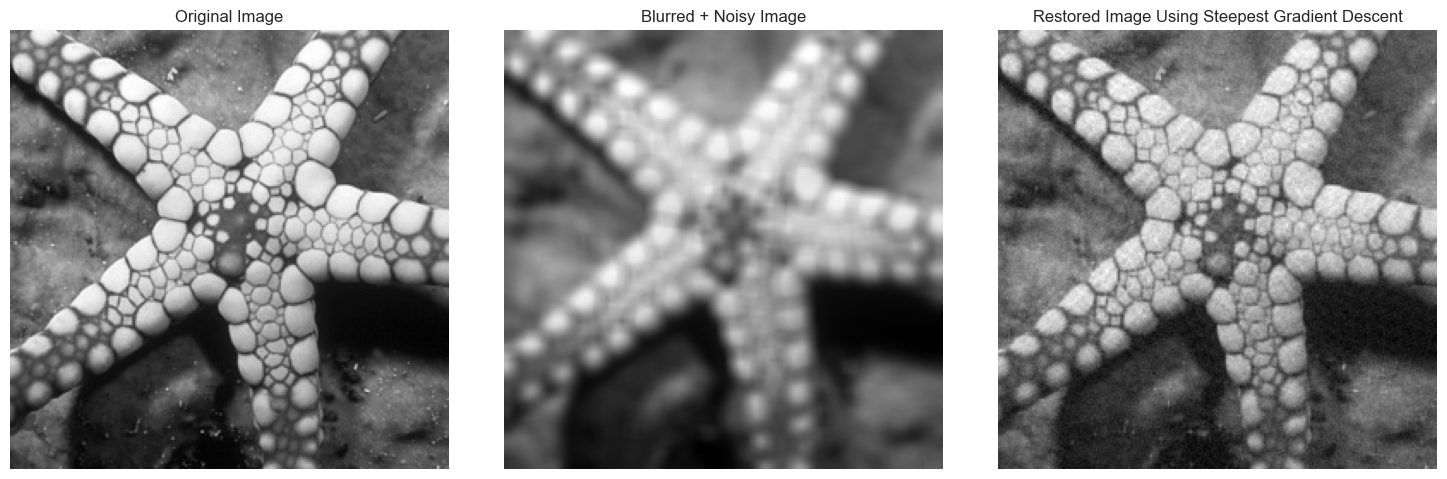

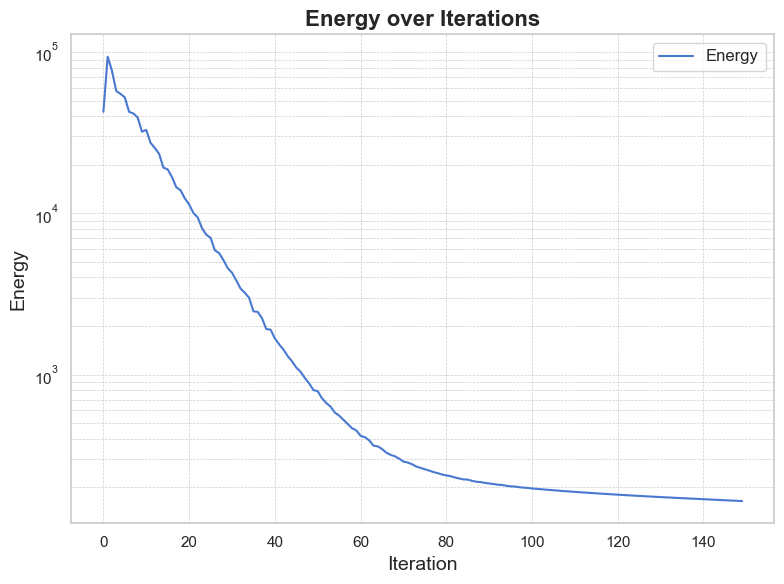

The original image psnr is :  inf dB
The noisy image psnr is :  21.580705797334883 dB
The reconstructed image psnr is :  28.722498551760424 dB


In [13]:
sigma = 0.01  
lambda_ = 0.01 
num_iterations = 150  
sigma_denoise = 0.001  

from AGD_NN import accelerated_steepest_descent_red_all_NN

# Run RED with steepest descent
restored_img_sg, energy_values = accelerated_steepest_descent_red_all_NN(
        y=noisy_img,
        kernel= kernel,
        sigma=sigma,
        lambda_= lambda_,
        num_iterations=num_iterations,
        model= CNN,
        tol= 1e-6
    )

show_img(original_img, noisy_img ,restored_img_sg, titles= ['Original Image', 'Blurred + Noisy Image','Restored Image Using Steepest Gradient Descent'])
convergence(energy_values)

print("The original image psnr is : ", psnr(original_img, original_img), "dB")
print("The noisy image psnr is : ",psnr(original_img, noisy_img), "dB")
print("The reconstructed image psnr is : ",psnr(original_img, restored_img_sg), "dB")

#### Bias Free Neural Network

100%|██████████| 150/150 [13:32<00:00,  5.41s/it]


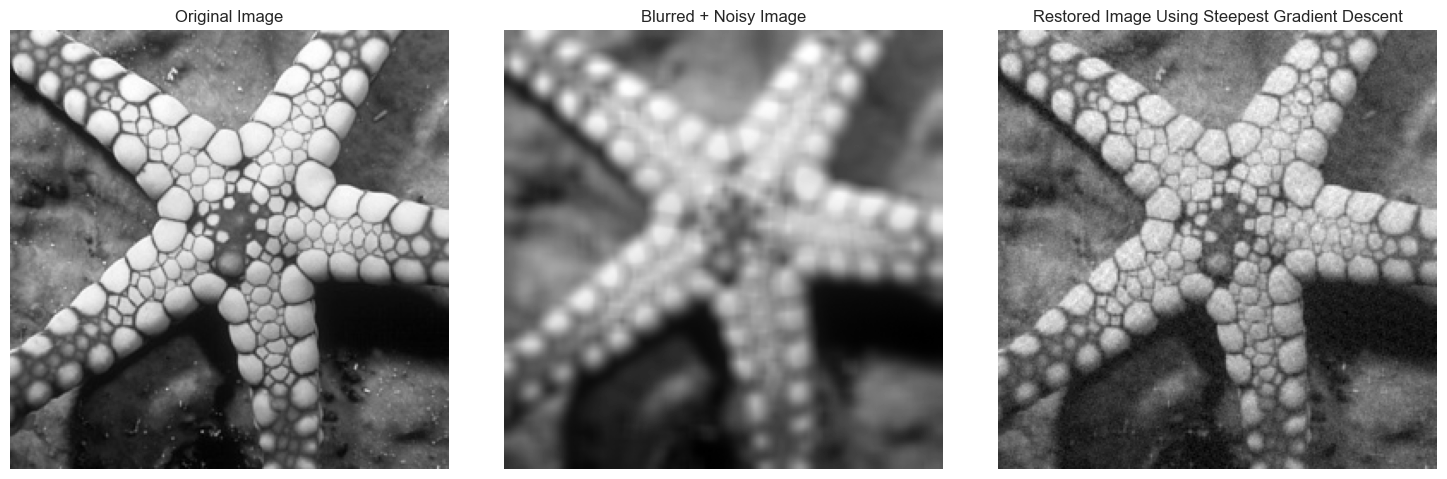

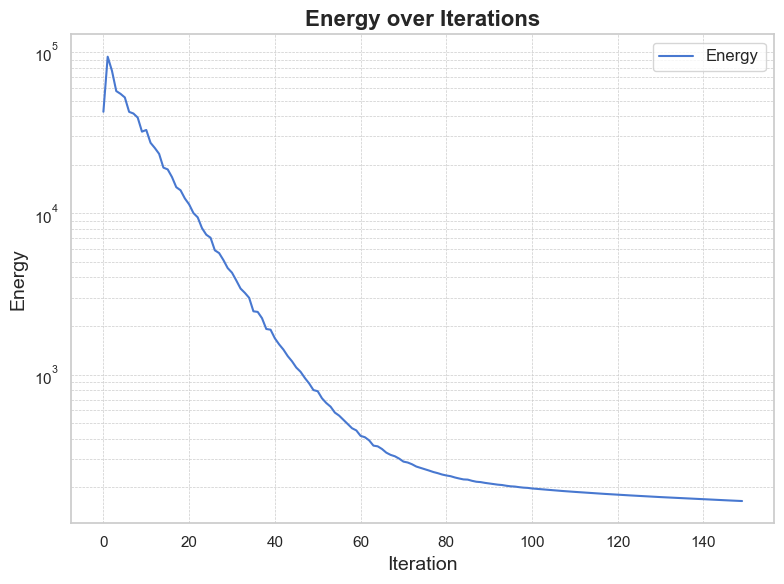

The original image psnr is :  inf dB
The noisy image psnr is :  21.580705797334883 dB
The reconstructed image psnr is :  28.72268561924009 dB


In [14]:
sigma = 0.01  
lambda_ = 0.01 
num_iterations = 150  
sigma_denoise = 0.001  

from AGD_NN import accelerated_steepest_descent_red_all_NN


restored_img_sg, energy_values = accelerated_steepest_descent_red_all_NN(
        y=noisy_img,
        kernel= kernel,
        sigma=sigma,
        lambda_= lambda_,
        num_iterations=num_iterations,
        model= BF_CNN,
        tol= 1e-6
    )

show_img(original_img, noisy_img ,restored_img_sg, titles= ['Original Image', 'Blurred + Noisy Image','Restored Image Using Steepest Gradient Descent'])
convergence(energy_values)

print("The original image psnr is : ", psnr(original_img, original_img), "dB")
print("The noisy image psnr is : ",psnr(original_img, noisy_img), "dB")
print("The reconstructed image psnr is : ",psnr(original_img, restored_img_sg), "dB")